In [77]:
import numpy as np
import pandas as pd

In [78]:
item_cats_df = pd.read_csv('../data/input/item_categories.csv')
item_df = pd.read_csv('../data/input/items.csv')
sales_train_df = pd.read_csv('../data/input/sales_train.csv')
sample_submission_df = pd.read_csv('../data/input/sample_submission.csv')
shops_df = pd.read_csv('../data/input/shops.csv')

test = pd.read_csv('../data/input/test.csv')

date_block_num:連続した月の番号。　2013年1月=0, 2013年2月=1, ..., 2015年10月=33  
item_cnt_day:商品の売れた数。目的変数。  
item_id:商品個別の識別子  

In [79]:
item_merge_df = pd.merge(item_df, item_cats_df, on='item_category_id', how='inner')

# 商品名、カテゴリ名、日付、価格のdataframeを作成
item_price_df = pd.merge(item_merge_df, sales_train_df, on='item_id', how='inner')

train = item_price_df.drop(['item_name', 'item_category_name'], axis=1)
display(train.head(10))

,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day
0,0,40,01.09.2014,20,54,58.0,1.0
1,2,40,24.08.2014,19,54,58.0,1.0
2,2,40,12.11.2014,22,54,58.0,1.0
3,3,40,05.07.2014,18,54,100.0,1.0
4,3,40,26.08.2014,19,54,58.0,1.0
5,4,40,19.09.2014,20,54,58.0,1.0
6,5,40,14.12.2014,23,54,28.0,1.0
7,6,40,19.07.2014,18,54,100.0,1.0
8,7,40,14.12.2014,23,54,28.0,1.0
9,8,40,26.08.2014,19,54,58.0,1.0


# 前処理

In [80]:
train = sales_train_df.copy()
# 日付型に変換
train['date'] = pd.to_datetime(train['date'])
# 負の値を除去
train = train[train['item_price'] > 0].copy()
train = train[train['item_cnt_day'] > 0].copy()

# 外れ値の確認

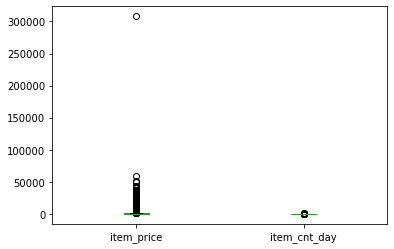

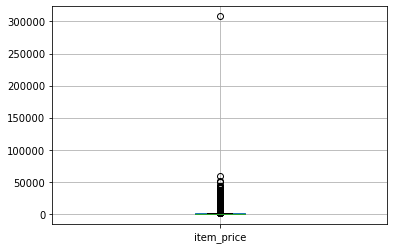

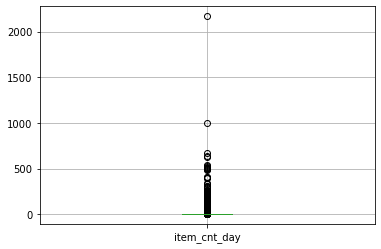

In [81]:
# 外れ値の確認
import matplotlib.pyplot as plt
train[['item_price', 'item_cnt_day']].plot.box()
plt.show()
train[['item_price']].boxplot()
plt.show()
train[['item_cnt_day']].boxplot()
plt.show()

# 外れ値の除去

In [82]:
# item_priceの外れ値処理
# 四分位範囲
q1 = train['item_price'].quantile(0.25)
q3 = train['item_price'].quantile(0.75)
iqr = q3 - q1# box_size
outliner_max1 = q3 + iqr * 1.5
outliner_min1 = q1 - iqr * 1.5

# 標準偏差
outliner_max2 = train['item_price'].mean() + train['item_price'].std() * 2
outliner_min2 = train['item_price'].mean() - train['item_price'].std() * 2

print('outliner min')
print('\tquantile:', outliner_min1)
print('\tstd:', outliner_min2)

print('outliner max')
print('\tquantile:', outliner_max1)
print('\tstd:', outliner_max2)

print('remain number')
print('outliner min')
print('\tquantile: ', len(train[train['item_price'] > outliner_min1]))
print('\tstd: ', len(train[train['item_price'] > outliner_min2]))
print('outliner max')
print('\tquantile: ', len(train[train['item_price'] < outliner_max1]))
print('\tstd: ', len(train[train['item_price'] < outliner_max2]))

outliner min
	quantile: -876.0
	std: -2565.5304132166502
outliner max
	quantile: 2124.0
	std: 4344.463915758676
remain number
outliner min
	quantile:  2928492
	std:  2928492
outliner max
	quantile:  2670894
	std:  2886128


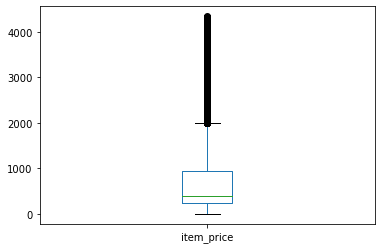

In [83]:
train[train['item_price'] < outliner_max2].item_price.plot.box()

In [84]:
train = train[train['item_price'] < outliner_max2].copy()

In [85]:
# item_cnt_dayの外れ値処理
# 四分位範囲
q1 = train['item_cnt_day'].quantile(0.25)
q3 = train['item_cnt_day'].quantile(0.75)
iqr = q3 - q1# box_size
outliner_max1 = q3 + iqr * 1.5
outliner_min1 = q1 - iqr * 1.5

# 標準偏差
outliner_max2 = train['item_cnt_day'].mean() + train['item_cnt_day'].std() * 2
outliner_min2 = train['item_cnt_day'].mean() - train['item_cnt_day'].std() * 2

print('outliner min')
print('\tquantile:', outliner_min1)
print('\tstandard dev:', outliner_min2)

print('outliner max')
print('\tquantile:', outliner_max1)
print('\tstandard dev:', outliner_max2)

print('remain number')
print('outliner min')
print('\tquantile: ', len(train[train['item_cnt_day'] > outliner_min1]))
print('\tstandard dev: ', len(train[train['item_cnt_day'] > outliner_min2]))
print('outliner max')
print('\tquantile: ', len(train[train['item_cnt_day'] < outliner_max1]))
print('\tstandard dev: ', len(train[train['item_cnt_day'] < outliner_max2]))

outliner min
	quantile: 1.0
	standard dev: -3.9985223565419497
outliner max
	quantile: 1.0
	standard dev: 6.49244362406716
remain number
outliner min
	quantile:  293922
	standard dev:  2886128
outliner max
	quantile:  0
	standard dev:  2865501


2865501


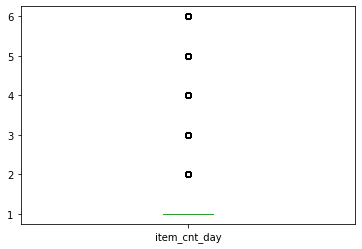

In [86]:
# 四分位範囲を使うと要素がなくなってしまう
# 標準偏差を使って、外れ値処理
train[train['item_cnt_day'] < outliner_max2].item_cnt_day.plot.box()
print(len(train[train['item_cnt_day'] < outliner_max2].item_cnt_day))

In [87]:
train = train[train['item_cnt_day'] < outliner_max2].copy()

# データ確認

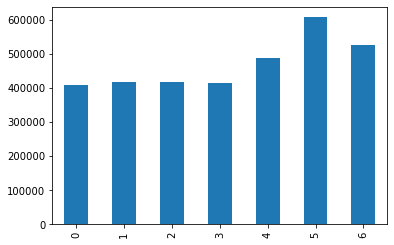

In [88]:
# 曜日を追加
# Sun:0, Mon:1, Tue:2, Wed:3, Thu:4, Fri:5, Sat:6
train['week'] = train['date'].dt.dayofweek

# 曜日毎の売上数
train.groupby('week').\
item_cnt_day.sum().reset_index().item_cnt_day.plot.bar()

# 1か月の合計を予測すればよいので、あくまで確認だけ

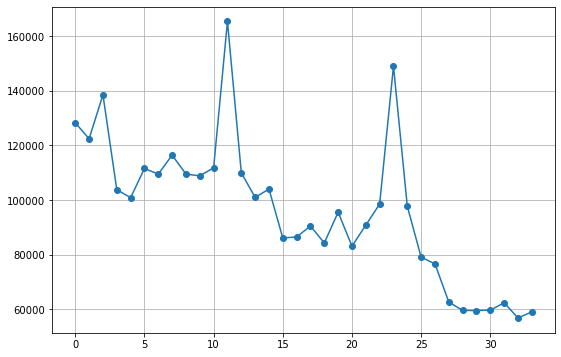

In [101]:
# 月ごとの売上数
train.groupby('date_block_num').\
item_cnt_day.sum().reset_index().item_cnt_day.plot(style='o-', figsize=(9, 6), grid=True)

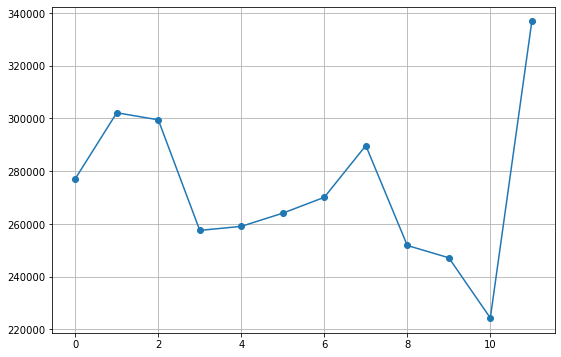

In [102]:
# 月を追加
train['month'] = train['date'].dt.month
train.groupby('month').\
item_cnt_day.sum().reset_index().item_cnt_day.plot(style='o-', figsize=(9,6), grid=True)

In [94]:
# 日付順に整列
train.sort_values('date', ascending=True, inplace=True)
train.reset_index(drop=True)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,week,month
0,2013-01-01,0,7,6495,699.0,1.0,1,1
1,2013-01-01,0,54,19736,149.0,1.0,1,1
2,2013-01-01,0,51,5822,884.0,2.0,1,1
3,2013-01-01,0,37,5580,399.0,1.0,1,1
4,2013-01-01,0,37,4901,1699.0,1.0,1,1
...,...,...,...,...,...,...,...,...
2865496,2015-12-10,33,24,7087,999.0,1.0,3,12
2865497,2015-12-10,33,7,10210,3499.0,1.0,3,12
2865498,2015-12-10,33,26,15256,399.0,1.0,3,12
2865499,2015-12-10,33,7,9404,199.0,1.0,3,12
